# Librerías

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from   datetime import timedelta
import datetime
import matplotlib as mpl
import glob
import os
from matplotlib import cm
import matplotlib.dates as mdates
from matplotlib import font_manager as fm
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import mat73
from pytides2.tide import Tide
import pytides2.constituent  as cons
import pytides2.astro as astro
from pyproj import Proj
import oceanlyz
import warnings
import matplotlib.pylab as pl
warnings.filterwarnings('ignore')
plt.style.use('default')


In [3]:
path_font=r"G:\My Drive\TESIS_MAESTRIA_PAULAE\Fonts\Quicksand"

prop1 = fm.FontProperties(fname=path_font+'\Quicksand-Medium.ttf')
prop2 = fm.FontProperties(fname=path_font+'\Quicksand-SemiBold.ttf')
prop1.set_size(12)

In [4]:
def load_mat_files(Test, file_name, Folder_variable):
    """
    INPUTS: 
    - Test: # Name of test folder (ej: TESTx)
    - file_name: Name of file to upload
    - Folder_variable: Name of variable of data (
        - Velocity
        - Water_level
        - Wave
        - Salinity_Temperature
    )
    ------------------------------------------------------------------------
    OUTPUT:
    - Dictionary of data
    """
    path = 'G:\My Drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS'
    prop_mat_data = mat73.loadmat(path+'\\'+Test+'\\'+Folder_variable+'\\'+file_name)
    dic_data = prop_mat_data['data']
    return dic_data

def angulo_norte(x,y):
    if x > 0 and y > 0:
        theta = 90 - (np.arctan(abs(y/x))*(180/np.pi))
    elif x < 0 and y > 0:
        theta = 270 + (np.arctan(abs(y/x))*(180/np.pi))
    elif x < 0 and y < 0:
        theta = 270 - (np.arctan(abs(y/x))*(180/np.pi))
    else:
        theta = 90 + (np.arctan(abs(y/x))*(180/np.pi))
    return theta

# FIELD DATA
- Currents
    - Velocity profiles
    - time series
    - time series profiles
- Water level
- Salinity and temperature profiles
- Waves
    - Pick period
    - Significant wave high

In [5]:
class field_data: 
    """
    This class allow to generate dataframe of data field for each variable
    # Field data
    - Currents
        - Velocity profiles
        - time series
        - time series profiles
        - water level (tide)
    - Salinity and temperature profiles
    - Waves
        - Pick period
        - Significant wave high
    """
    def __init__(self, sensor_type):
        """
        Argumentos:
        paths: rutas de los archivos de las diferentes variables
        sensor_type: Tipo de sensor awac (AW600/AW1000)
        """
        self.sensor_type = sensor_type
    

    def velocity(self, path, depth_sensor, sensor_head_to_level, file_name1, file_name2, head_free):
        """
        This function return velocity components, velocity magnitude, and
        velocity direction.
        Input:
        - path: is the path to read velocity data
        - depth: is the depth that sensor was deployed
        - Sensor_head_to_level: water head over sensor until water level
        - head_free: free higth where sensor don't record data 
        ------------------------------------------------------------------
        Return:
        df_awu: dataframe of u velocity component
        df_awv: dataframe of v velocity component
        """ 
        depth = depth_sensor + (sensor_head_to_level+head_free)*-1
        r_v1 = path+file_name1
        r_v2 = path+file_name2
        List_namesv1 = []
        List_namesv2 = []
        if self.sensor_type == 'AW600': 
            for i in range (0,30):
                if i < 16:
            #         print(i+1, depth[i])
                    names_v1 = 'u_'+str(int(depth[i]))
                    names_v2 = 'v_'+str(int(depth[i]))
                else:
                    names_v1 = 'u_'+str(i+1)
                    names_v2 = 'v_'+str(i+1)
                List_namesv1.append(names_v1)
                List_namesv2.append(names_v2)
        else: 
            for i in range (0,40):
                if i < 37:
            #         print(i+1, depth[i])
                    names_v1 = 'u_'+str(depth[i])
                    names_v2 = 'v_'+str(depth[i])
                else:
                    names_v1 = 'u_'+str(i+1)
                    names_v2 = 'v_'+str(i+1)
                List_namesv1.append(names_v1)
                List_namesv2.append(names_v2)
        df_awu=pd.read_csv(r_v1,delimiter='\s+',encoding = "ISO-8859-1",names = List_namesv1)
        df_awv=pd.read_csv(r_v2,delimiter='\s+',encoding = "ISO-8859-1",names = List_namesv2)

        #-----------tiempo------------------------------
        escala_temporal = 30                 # resolución temporal en minutos
        if self.sensor_type == 'AW600':
            for i in range (17,31):
                df_awu = df_awu.drop(['u_'+str(i)], axis = 1)
                df_awv = df_awv.drop(['v_'+str(i)], axis = 1)
            date_ini = datetime.datetime(2021,11,6,7,0)      # Incio de almacenamiento de datos de AWAC
            date_fin = datetime.datetime(2021,11,14,12,30)    # Fin de almacenamiento de datos de AWAC
            minutos =int((date_fin-date_ini).days*24 + (date_fin-date_ini).seconds/3600)*60+escala_temporal  # minutos de almacenamiento en swan

        else:
            for i in range (38,41):
                df_awu = df_awu.drop(['u_'+str(i)], axis = 1)
                df_awv = df_awv.drop(['v_'+str(i)], axis = 1)
            date_ini = datetime.datetime(2021,11,6,7,0)      # Incio de almacenamiento de datos de AWAC
            date_fin = datetime.datetime(2021,11,14,14,30)    # Fin de almacenamiento de datos de AWAC
            minutos =int((date_fin-date_ini).days*24 + (date_fin-date_ini).seconds/3600)*60+(escala_temporal*2)  # minutos de almacenamiento en swan
        df_awu = df_awu.reset_index(drop=True)
        df_awv = df_awv.reset_index(drop=True)
        time_flow = np.array([date_ini + timedelta(minutes=m) for m in range(0,int(minutos),escala_temporal)]) # Vector de timepos por hora, como se registro con Swan
        print(df_awv.shape, time_flow.shape)
        df_awu = df_awu.set_index(time_flow)
        df_awv = df_awv.set_index(time_flow)
        return df_awu, df_awv

    
    def water_level (self,path, ini_date, end_date): 
        """
        This fucntion allow read water level data
        Inputs: 
        path: path of file sensor data
        ini_date: fecha incial de registro de datos buenos 
        end_date: fecha final de resgistro de datos buenos
        ---------------------------------------------------------
        Return: 
        df_marea: data frame of water level
        """
        
        df_data = pd.read_csv(path,sep=',',encoding = "ISO-8859-1",header=21, names = 
            ['UNITS', 'Timecode', 'Raw', '°C', 'Raw.1', 'bar', 'Raw.2', 'm', 'Unnamed: 8']) # Modeficar ruta

        P = df_data['bar'].values                 # Obtener los valores de presión [bares] 
        time2 = df_data['Timecode'].values             # Obtener los tiempos
        fechas_str = (i for i in time2)              # Convertir las fechas en un str
        time_data = np.array([datetime.datetime.strptime(i,'%m/%d/%Y %I:%M:%S %p') for i in fechas_str]) # Convertir fechas en arreglo de numpy con datetime.datetime 
        h = (P-1.01325)*(100000/(9.8*1027))
        df = pd.DataFrame(data=h,index= time_data,columns=['h'])
        df = df[ini_date:end_date]
        marea = df.h.values -df.h.mean()
        t = time_data[np.where(time_data == ini_date)[0][0]:np.where(time_data == end_date)[0][0]+1]
        df_marea = pd.DataFrame(data =marea, index=t, columns= ['waterlevel'])
        return df_marea
    
    
    def dic_sal_temp (self, paths):
        """
        in: 
        - paths: list of data paths of salinity and temperature profiles
        -----------------------------------------------------------------
        out:
        - Datos: dictionary of data points whit dataframe of salinity and temeperature profiles
        - Cord: Matriz de cordenadas [longitude, latitude]
        """
        def metadata (path):
            """
            in: 
            - path: path of data
            ---------------------------------------
            out: 
            - metadata: Data frame of each profile 
            """
            metadata = pd.read_csv(path, delimiter = ",", nrows = 23,names=['Device', 'Value']) # Modeficar ruta
            for i in range (0, metadata.shape[0]):
                if metadata['Device'].values[i][0:2]=='% ':
                    metadata['Device'][i] = metadata['Device'][i][2:len(metadata['Device'][i])] 

            # metadata.set_index("% Device")
            return metadata

        Datos = {}
        time = []
        lat = np.zeros(shape = len(paths))
        lon = np.zeros(shape = len(paths))
        for i in range (0, len(paths)):
            metadata_ = metadata(paths[i])
            lat[i] = float(metadata_[metadata_.Device == 'Start latitude'].Value.values)
            lon[i] = float(metadata_[metadata_.Device == 'Start longitude'].Value.values)
            Time = metadata_[metadata_.Device == 'Cast time (local)'].Value.values
            time.append(Time)
            if (i < 9):
                name = 'P0'+str(i+1)+' '+str(Time[0])
            else:
                name = 'P'+str(i+1)+' '+str(Time[0])
            #     print(name)
            data = pd.read_csv(paths[i], delimiter = ",", header = 28) # Modeficar ruta
            df = pd.DataFrame(data = np.c_[data['Depth (Meter)'].values,data['Temperature (Celsius)'].values,\
                                data['Salinity (Practical Salinity Scale)'].values], columns =['Depth','Temp','Sal'])
            Datos.setdefault(name,df)
        Cord = np.c_[lon, lat]
        return Datos, Cord
    
    
    def waves (self, paths, samples, fecha_inicio, fecha_fin, fecha_ideploid, fecha_fdeploid):
        """
        sensor: str(Tipo de sensor que se usó) [AW600 -AW1000]
        paths: Represent the group of paths files
        Samples: Number of samples each sea state
        fecha_inicio: fecha inicial de registro del sensor (datetime)
        fecha_final: fecha final de registro del sesnor (datetime)
        h_depth: profundad del punto de ubicación del sensor 
        h_sensor: Altura del sensor medida desde el fondo
        escala_temporal: cada cuntas horas se miden los registros
        -------------------------------------------------------------------
        Return: 
        Data Frame of presure sensor
        """
        
        def CutByTime(time_data,pot_2,fs):
            """
            time_data = datos con el registro de tiempos (index or series)
            pot_2 = potencia de dos para determinar el numero de datos (1024 --> 2^10 - 2048 --> 2^11)
            fs = frecuencia de muestreo del sensor (1 Hz - 2 Hz)
            """
            series_data = pd.Series(index=time_data)
            time_limits = time_data.map(lambda t: datetime.datetime.combine(t.date() , datetime.time(t.hour))).unique()
            time_limits = np.repeat(time_limits,2)
            time_limits_2 = np.copy(time_limits)

            for k in range(1,len(time_limits),2):
                time_limits_2[k] = time_limits[k] + timedelta(seconds = (2**pot_2 -1)/fs)

            time_mask = []

            for i in range(0,len(time_limits_2)-1,2):
                tmp_time = series_data.loc[time_limits_2[i]:time_limits_2[i+1]]
                time_mask.append(tmp_time.index.values)

            time_mask = np.concatenate(time_mask)

            return pd.Series(time_mask)

        Presion = np.zeros(len(paths)*samples)
        if self.sensor_type == 'AW600':
            time_df = np.zeros(shape = (len(paths)*samples), dtype='datetime64[s]')
            for i in range(len(paths)):
                data_aw=pd.read_csv(paths[i],delimiter='\s+',encoding = "ISO-8859-1", names=["Month","Day","Year","Hour",'Minute','Second','Pressure','Spare','Analog input','Velocity (Beam1|X|East)','Velocity (Beam2|Y|North)','Velocity (Beam3|Z|Up)','Velocity (Beam4)','Amplitude (Beam1)','Amplitude (Beam2)','Amplitude (Beam3)','Amplitude (Beam4)'])
                Presion[samples*i:samples*(i+1)] = data_aw.Pressure.values
                time_burst = np.zeros(shape = (samples), dtype = 'datetime64[s]')
                for j in range (0,int(data_aw.shape[0])):
                    time_burst[j] = datetime.datetime(data_aw.Year.values[j],data_aw.Month.values[j],\
                                        data_aw.Day.values[j],data_aw.Hour.values[j],\
                                        data_aw.Minute.values[j],int(data_aw.Second.values[j]))
                time_df[samples*i:samples*(i+1)] = time_burst
        elif self.sensor_type == 'AW1000':
            fecha_ideploid = fecha_ideploid.strftime("%Y-%m-%d %H:%M:%S")
            fecha_fdeploid = fecha_fdeploid.strftime("%Y-%m-%d %H:%M:%S")
            time_global = pd.date_range(start=fecha_ideploid, end=fecha_fdeploid , freq='0.5S')
            time_df = CutByTime(time_global,11,2)
            for i in range(0,len(paths)):
                data_aw =pd.read_csv(paths[i], delimiter='\s+', encoding = "ISO-8859-1", names=['Burst counter','Ensemble counter','Pressure','AST Distance1 (Beam4)','AST Distance2 (Beam4)','AST Quality (Beam4)','Analog input','Velocity (Beam1)','Velocity (Beam2)', 'Velocity (Beam3)', 'Amplitude (Beam1)', 'Amplitude (Beam2)', 'Amplitude (Beam3)'])
                Presion[samples*i:samples*(i+1)] = data_aw.Pressure.values
        df = pd.DataFrame(data=Presion,index= time_df,columns=["Pres"]) 
        df = df[fecha_inicio:fecha_fin]
        hours = int((fecha_fin-fecha_inicio).days*24 + (fecha_fin-fecha_inicio).seconds/3600) # Horas de muestreo
        time_h = np.array([fecha_inicio + timedelta(hours=h) for h in range(0,hours,1)]) # Estado de mar de una hora
        return df , time_h
    
    def OCEANLYZ(self,data,freq_S,rho,method,zp,fmaxpcorr):
        """
        Inputs: 
        sensor_type = Especificar tipo de sensor --> Aqualogger o RBR
        data = dataframe con la información de presión del sensor (en bar o dbar)
        freq_S = Frecuencia de muestreo del equipo en Hz
        rho = Densidad del agua del sitio de analisis
        method = Definir el metodo de analisis --> spectral o zerocross
        zp = Distancia desde el fondo hasta el sensor
        fmaxpcorr = Frecuencia maxima (Hz) para la aplicación del factor de corrección Kp
        -----------------------------------------------------------------------------------------
        Outputs: 
        ocn.wave: Dicionario con los parametros del olejae ('Eta', 'Hm0', 'Tp', 'fp', 'f', 'Syy', 'Burst_Data', 'Field_Names')
        """
        ocn = oceanlyz.oceanlyz()

        if self.sensor_type=="AW600":
            ocn.data=(((data["Pres"]-10.1325)*10000).values).copy()
            ocn.fs=1
            ocn.n_burst=int(len(data)/1024)

        elif self.sensor_type=="AW1000":
            ocn.data=(((data["Pres"]-10.1325)*10000).values).copy()
            ocn.fs=2
            ocn.n_burst=int(len(data)/2048)

        ocn.InputType='pressure'
        ocn.OutputType='wave'
        ocn.burst_duration=1024
        ocn.Rho=rho
        ocn.heightfrombed=zp
        ocn.AnalysisMethod=method
        ocn.dispout='no'

        # parameters for spectral analysis

        ocn.fmin=0.05                   #Only required if ocn.AnalysisMethod='spectral'
        ocn.fmax=ocn.fs/2                #Only required if ocn.AnalysisMethod='spectral'
        ocn.fmaxpcorrCalcMethod='auto'   #Only required if ocn.InputType='pressure' and ocn.AnalysisMethod='spectral'
        ocn.Kpafterfmaxpcorr='constant'  #Only required if ocn.InputType='pressure' and ocn.AnalysisMethod='spectral'
        ocn.fminpcorr=0.15               #Only required if ocn.InputType='pressure' and ocn.AnalysisMethod='spectral'
        ocn.fmaxpcorr=fmaxpcorr          #Only required if ocn.InputType='pressure' and ocn.AnalysisMethod='spectral'
        

        if freq_S==1:
            ocn.nfft = 2**8

        elif freq_S==2:
            ocn.nfft = 2**9

        #Run OCEANLYZ
        ocn.runoceanlyz()

        return ocn.wave

# MODEL DATA

*DELFT 3D*
- Velocity:
    - Currents (velocity components)
    - Profiles
    - time series profiles
- Waves: 
    - Significant wave Hight 
    - Peak periodo
    - Direction
- Temperature and Salinity
    - Profiles
    - Time series
- Water level

In [6]:
class model_data():
    """
    This class allow to generate dataframe of model data for each variable
    """
    def __init__(self, id_point, Test):
        """
        Argumentos:
        id_point: Nombre del punto de observacion
        Test: Name of directory of files ej (TESTx)
        """
        self.id_point = id_point
        self.Test = Test
    
    def load_mat_files(self, file_name, Folder_variable):
        """
        INPUTS: 
        - Test: # Name of test folder (ej: TESTx)
        - file_name: Name of file to upload
        - Folder_variable: Name of variable of data (
            - Velocity
            - Water_level
            - Wave
            - Salinity_Temperature
        )
        ------------------------------------------------------------------------
        OUTPUT:
        - Dictionary of data
        """
        Test = self.Test
        path = 'G:\My Drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS'
        prop_mat_data = mat73.loadmat(path+'\\'+Test+'\\'+Folder_variable+'\\'+file_name)
        dic_data = prop_mat_data['data']
        return dic_data
    
    def velocity_points(self):
        """Inputs: 
        id_point: Nombre del punto de observacion
        Test: Name of directory of files ej (TESTx)
        -----------------------------------------------------
        Return: 
        df of velocity magnitude, velocity dir, velocity u component, velocity v component
        """
        id_point = self.id_point
        dic_angulo = self.load_mat_files(file_name='horizontal_velocity_angulo_'+id_point+'.mat', Folder_variable='Velocity')
        py_datetime = [datetime.datetime.fromordinal(int(i)) + timedelta(days=i%1) - timedelta(days = 366) for i in dic_angulo['Time']]
        time_df = [datetime.datetime(i.year, i.month, i.day, i.hour, i.minute, i.second) for i in py_datetime]
        df_dir = pd.DataFrame(dic_angulo['Val']*360/(2*np.pi), columns = [[dic_angulo['Z'][:,i].mean() for i in range(0, dic_angulo['Z'].shape[1])]], index =time_df )
        
        dic_data_vel = self.load_mat_files(file_name='horizontal_velocity_'+id_point+'.mat', Folder_variable='Velocity')
        df_vel = pd.DataFrame(dic_data_vel['Val'], columns = [[dic_angulo['Z'][:,i].mean() for i in range(0, dic_angulo['Z'].shape[1])]], index =time_df )    
        
        dic_data_vel_u = self.load_mat_files(file_name='horizontal_velocity_u_'+id_point+'.mat', Folder_variable='Velocity')
        df_u = pd.DataFrame(dic_data_vel_u['Val'], columns = [[dic_angulo['Z'][:,i].mean() for i in range(0, dic_angulo['Z'].shape[1])]], index =time_df )
        
        dic_data_vel_v = self.load_mat_files(file_name='horizontal_velocity_v_'+id_point+'.mat', Folder_variable='Velocity')
        df_v = pd.DataFrame(dic_data_vel_v['Val'], columns = [[dic_angulo['Z'][:,i].mean() for i in range(0, dic_angulo['Z'].shape[1])]], index =time_df )

        return df_vel, df_dir, df_u, df_v
    
    def wave(self, ind_x, ind_y):
        """Inputs: 
        id_point: Nombre del punto de observacion
        Test: Name of directory of files ej (TESTx)
        ind_x: indice de la posición en x (Longitudes)
        ind_y: índice de la posición en y (Latitudes)
        -----------------------------------------------------
        Return: 
        df of stadistic parameters of wave
        """
        dic_Hs = self.load_mat_files(file_name='hsig_wave_height.mat', Folder_variable='Wave')
        dic_Tp = self.load_mat_files(file_name='relative_peak_wave_period.mat', Folder_variable='Wave')
        py_datetime = [datetime.datetime.fromordinal(int(i)) + timedelta(days=i%1) - timedelta(days = 366) for i in dic_Hs['Time']]
        time_df = [datetime.datetime(i.year, i.month, i.day, i.hour, i.minute, i.second) for i in py_datetime]
        df_wave = pd.DataFrame({'Hs':dic_Hs['Val'][:,ind_x,ind_y], 'Tp':dic_Tp['Val'][:,ind_x,ind_y]}, index = time_df)
        return df_wave
    
    def water_level(self):
        """Inputs: 
        id_point: Nombre del punto de observacion
        Test: Name of directory of files ej (TESTx)
        -----------------------------------------------------
        Return: 
        df of velocity magnitude, velocity dir, velocity u component, velocity v component
        """
        id_point = self.id_point
        dic_wl = self.load_mat_files(file_name='water_level_'+id_point+'.mat', Folder_variable='Water_level')
        py_datetime = [datetime.datetime.fromordinal(int(i)) + timedelta(days=i%1) - timedelta(days = 366) for i in dic_wl['Time']]
        time_df = [datetime.datetime(i.year, i.month, i.day, i.hour, i.minute, i.second) for i in py_datetime]
        df_wl = pd.DataFrame(dic_wl['Val'], index = time_df, columns=['waterlevel'])
        return df_wl

# FIELD vs MODEL Data

In [7]:
# Llamar las calses de los datos de campo
class_field_db_AW600 = field_data(sensor_type='AW600') 
class_field_db_AW1000 = field_data(sensor_type='AW1000') 

In [8]:
# Llamar las calses de los datos del modelo
class_db_model_northeast = model_data(id_point='barrera', Test= 'TEST8')
class_db_model_west = model_data(id_point='cove', Test= 'TEST8')


## Velocidad

In [9]:
def direction (dfu, dfv):
    dic_direc = {}
    for i in range(dfu.shape[1]):
        direc_flow = np.zeros(dfu.shape[0])
        for j in range(dfu.shape[0]):
            direc_flow[j] = angulo_norte(dfu.iloc[j,i], dfv.iloc[j,i])
        dic_direc.update({dfu.columns[i]:direc_flow})
    df_direc = pd.DataFrame(data = dic_direc, index = dfu.index)
    return df_direc

### Field data

In [10]:

# AWAC 600 
sensor_head_to_level=np.array([1.50, 2.50, 3.50, 4.50, 5.50, 6.50, 7.50, 8.50, 9.50,10.50,11.50,12.50,13.50,14.50,15.50,16.50])
path_velaw600 = "G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\DATOS_CAMPO\DATOS_SAI_4_15_nov_2021\AWAC600"
df_aw600_ufield, df_aw600_vfield = class_field_db_AW600.velocity(path=path_velaw600,depth_sensor=17.7, sensor_head_to_level = sensor_head_to_level,file_name1="\AW60002.v1",file_name2= "\AW60002.v2",head_free= 1.20 )
df_aw600_ufield = df_aw600_ufield[datetime.datetime(2021,11,6,10,30):datetime.datetime(2021,11,14,5,30)]
df_aw600_vfield = df_aw600_vfield[datetime.datetime(2021,11,6,10,30):datetime.datetime(2021,11,14,5,30)]
df_aw600_vel_field =np.sqrt((df_aw600_ufield.values)**2+(df_aw600_vfield.values)**2)
df_aw600_vel_field = pd.DataFrame(data = df_aw600_vel_field, index = df_aw600_ufield.index, columns = df_aw600_ufield.columns)
df_direc_aw600 = direction(dfu=df_aw600_ufield, dfv=df_aw600_vfield)

# AWAC 1000
sensor_head_to_level = np.arange(0.50, 19,0.50)
path_velaw1000 = "G:\My Drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\DATOS_CAMPO\DATOS_SAI_4_15_nov_2021\AWAC1000"
df_aw1000_ufield, df_aw1000_vfield = class_field_db_AW1000.velocity(path =path_velaw1000,depth_sensor=19.2, sensor_head_to_level= sensor_head_to_level,file_name1="\AW100002.v1", file_name2="\AW100002.v2", head_free= 0.70)
df_aw1000_ufield = df_aw1000_ufield[datetime.datetime(2021,11,6,13,0):datetime.datetime(2021,11,14,5,30)]
df_aw1000_vfield = df_aw1000_vfield[datetime.datetime(2021,11,6,13,0):datetime.datetime(2021,11,14,5,30)]
df_aw1000_vel_field =np.sqrt((df_aw1000_ufield.values)**2+(df_aw1000_vfield.values)**2)
df_aw1000_vel_field = pd.DataFrame(data = df_aw1000_vel_field, index = df_aw1000_ufield.index, columns = df_aw1000_ufield.columns)
df_direc_aw1000 = direction(dfu=df_aw1000_ufield, dfv=df_aw1000_vfield)

(395, 16) (395,)
(400, 37) (400,)


In [61]:
df_aw600_vel_field.columns[0][-2:]

'15'

In [77]:
for i in range (0,len(df_aw600_vel_field.columns)):
    print(str(df_aw600_vel_field.columns[i])[-2:])

15
14
13
12
11
10
_9
_8
_7
_6
_5
_4
_3
_2
_1
_0


In [80]:
colors_cm.shape 

(37, 4)

In [79]:
 len(df_aw600_vel_field.columns)

16

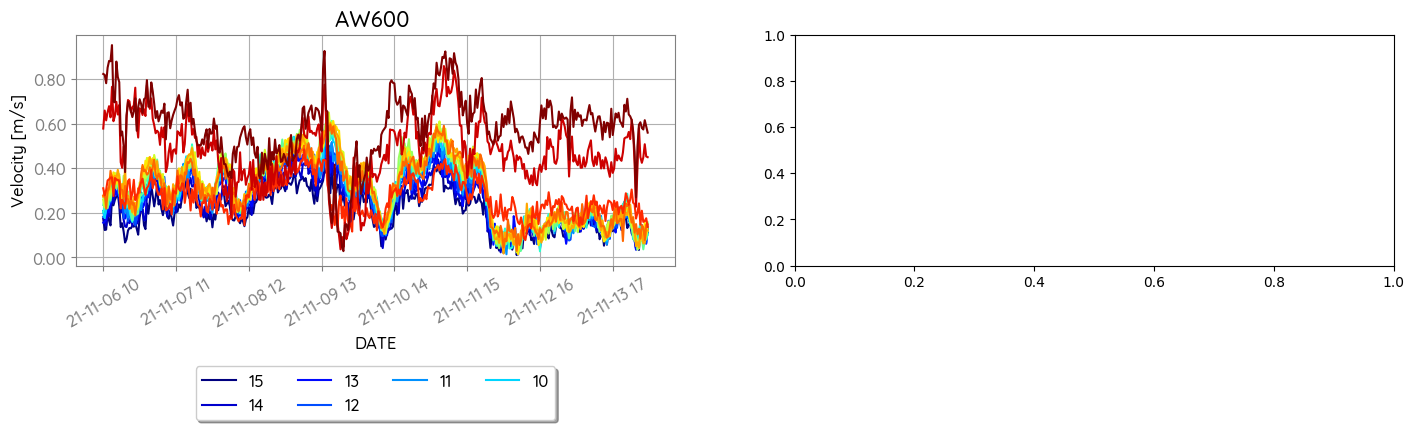

In [83]:
fig, axs = plt.subplots(1,2, figsize= (17, 3))
ax = axs[0]
ticklabels = df_aw600_vel_field.index[::50]
colors_cm = pl.cm.jet(np.linspace(0,1, len(df_aw600_vel_field.columns)))
for i in range (0,len(df_aw600_vel_field.columns)):
    ax.plot(df_aw600_vel_field.iloc[:,i], color = colors_cm[i], label =str(df_aw600_vel_field.columns[i])[-2:])
ax.get_xticklabels()
ax.set_xticks(ticklabels)
date_format = mdates.DateFormatter('%y-%m-%d %H')
ax.xaxis.set_major_formatter(date_format)
xlabels_aw6 = ax.get_xticklabels()
ax.set_ylabel ('Velocity [m/s]',size=12,fontproperties=prop1)
ax.set_xlabel ('DATE',size=12,fontproperties=prop1)
ax.set_yticklabels(ax.get_yticks(), fontproperties=prop1,color='gray',size = 12)
ax.spines['left'].set_color('gray')
ax.spines['right'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['top'].set_color('gray')
ax.tick_params('y', colors='tab:gray')
ax.tick_params('x', colors='tab:gray')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_title('AW600 ',size = 16,fontproperties=prop1)   # Subtítulo de la figura
ax.grid()
for label in ax.get_xticklabels():
    label.set_fontproperties(prop1)
    label.set_color('gray')
    label.set_size(12)
ax.tick_params(axis='x', labelrotation = 30)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4),
          fancybox=True, shadow=True, ncol=4, fontsize = 10,prop=prop1)
#------------------------------------------------------------------------------------------------------------------

# ax1 = axs[1]
# colors_cm = pl.cm.jet(np.linspace(0,1, len(df_aw1000_vel_field.columns)))
# for i in range (0,len(df_aw1000_vel_field.columns)):
#     ax1.plot(df_aw1000_vel_field.iloc[:,i], color = colors_cm[i], label=df_aw1000_vel_field.columns[i][-4:])
# ticklabels = df_aw1000_vel_field.index[::50]
# ax1.set_xticks(ticklabels)
# date_format = mdates.DateFormatter('%y-%m-%d %H')
# ax1.xaxis.set_major_formatter(date_format)
# xlabels_aw1 = ax1.get_xticklabels()
# ax1.set_ylabel ('Velocity [m/s]',size=12,fontproperties=prop1)
# ax1.set_xlabel ('DATE',size=12,fontproperties=prop1)
# ax1.set_yticklabels(ax1.get_yticks(), fontproperties=prop1,color='gray',size = 12)
# ax1.spines['left'].set_color('gray')
# ax1.spines['right'].set_color('gray')
# ax1.spines['bottom'].set_color('gray')
# ax1.spines['top'].set_color('gray')
# ax1.tick_params('y', colors='tab:gray')
# ax1.tick_params('x', colors='tab:gray')
# ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# ax1.set_title('AW1000 ',size = 16,fontproperties=prop1)   # Subtítulo de la figura
# ax1.grid()
# for label in ax1.get_xticklabels():
#     label.set_fontproperties(prop1)
#     label.set_color('gray')
#     label.set_size(12)
# ax1.tick_params(axis='x', labelrotation = 30)
# xlabels_aw1 = ax1.get_xticklabels()
# ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4),
#           fancybox=True, shadow=True, ncol=4, fontsize = 10,prop=prop1)

### Model data

In [11]:
# Northeast
df_vel_aw600_model, df_dir_aw600_model, df_u_aw600_model, df_v_aw600_model = class_db_model_northeast.velocity_points()
df_field_model_vel_aw600 =df_vel_aw600_model.loc[df_aw600_vel_field.index.intersection(df_vel_aw600_model.index)]
df_field_model_dir_aw600 =df_dir_aw600_model.loc[df_direc_aw600.index.intersection(df_dir_aw600_model.index)]
df_field_model_u_aw600 =df_u_aw600_model.loc[df_aw600_ufield.index.intersection(df_u_aw600_model.index)]
df_field_model_v_aw600 =df_v_aw600_model.loc[df_aw600_vfield.index.intersection(df_v_aw600_model.index)]


# West
df_vel_aw1000_model, df_dir_aw1000_model, df_u_aw1000_model, df_v_aw1000_model = class_db_model_west.velocity_points()
df_field_model_vel_aw1000 =df_vel_aw1000_model.loc[df_aw1000_vel_field.index.intersection(df_vel_aw1000_model.index)]
df_field_model_dir_aw1000 =df_dir_aw1000_model.loc[df_direc_aw1000.index.intersection(df_dir_aw1000_model.index)]
df_field_model_u_aw1000 =df_u_aw1000_model.loc[df_aw1000_ufield.index.intersection(df_u_aw1000_model.index)]
df_field_model_v_aw1000 =df_v_aw1000_model.loc[df_aw1000_vfield.index.intersection(df_v_aw1000_model.index)]



### Plots y analisis

In [146]:
df_field_aw6_plot = df_aw600_vel_field[['u_0', 'u_5', 'u_10', 'u_15']]
df_field_aw6_plot.columns = ['0 m [Field]', '5 m [Field]', '10 m [Field]', '15 m [Field]']
df_model_aw6_plot = df_field_model_vel_aw600.iloc[:,[0,-3,-2,-1]]
df_model_aw6_plot.columns = ['0 m [Model]', '5 m [Model]', '10 m [Model]', '15 m [Model]']

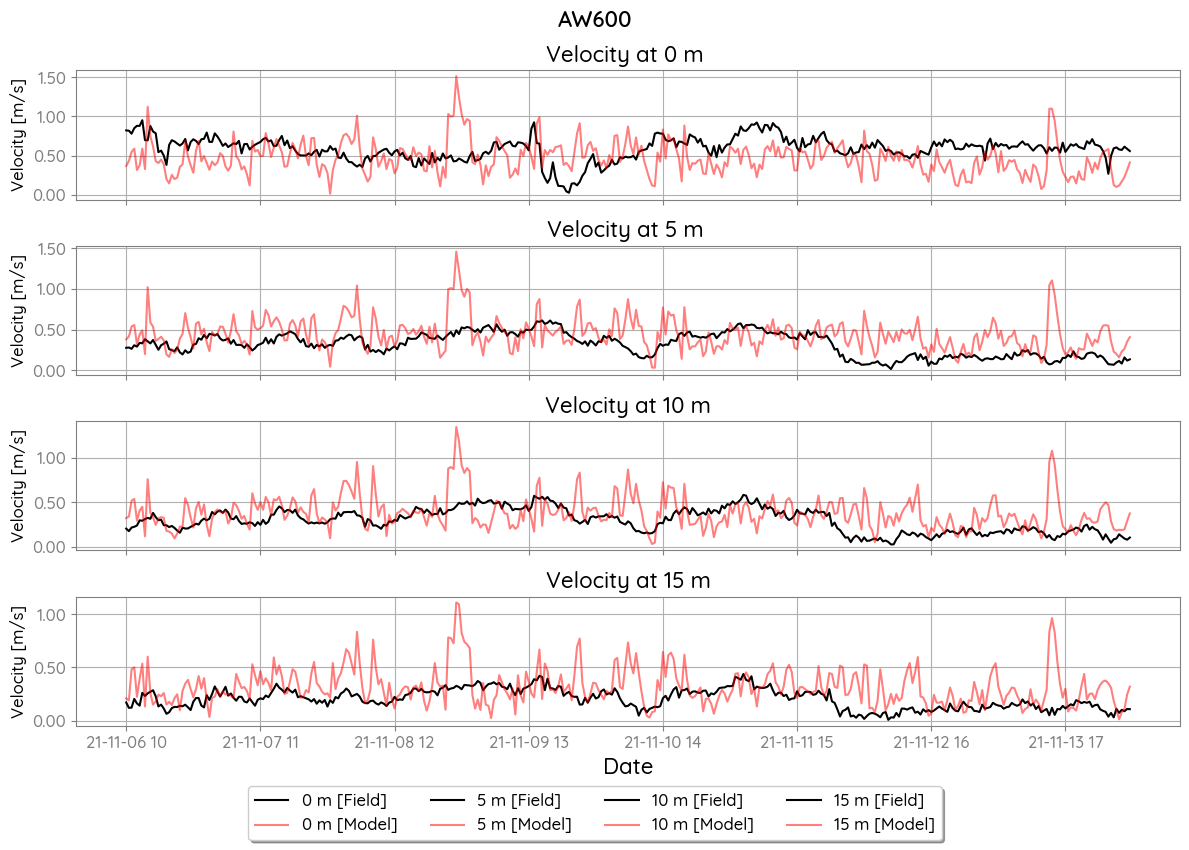

In [155]:
fig1, axs = plt.subplots(len(df_field_aw6_plot.columns), 1, figsize = (12,8), sharex = True)
for k in range (len(df_field_aw6_plot.columns)):
    ax = axs[k]
    ticklabels = df_field_aw6_plot.index[::50]
    ax.plot(df_field_aw6_plot.iloc[:,k], label =df_field_aw6_plot.columns[k], color = 'k' )
    ax.plot(df_model_aw6_plot.iloc[:,k], label = df_model_aw6_plot.columns[k], color = 'red', alpha = 0.5)

    ax.set_xticks(ticklabels)
    date_format = mdates.DateFormatter('%y-%m-%d %H')
    ax.xaxis.set_major_formatter(date_format)
    ax.set_ylabel ('Velocity [m/s]',size=12,fontproperties=prop1)
    ax.set_yticklabels(ax.get_yticks(), fontproperties=prop1,color='gray',size = 12)
    ax.spines['left'].set_color('gray')
    ax.spines['right'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.spines['top'].set_color('gray')
    ax.tick_params('y', colors='tab:gray')
    ax.tick_params('x', colors='tab:gray')
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.set_title('Velocity at '+df_field_aw6_plot.columns[k][0:4],size = 16,fontproperties=prop1)   # Subtítulo de la figura
    ax.grid()
    for label in ax.get_xticklabels():
        label.set_fontproperties(prop1)
        label.set_color('gray')
        label.set_size(12)

ax.set_xlabel ('Date',size=16,fontproperties=prop1)
fig1.suptitle("AW600", size = 16,fontproperties=prop2)     # Titulo de la figura
fig1.tight_layout()
fig1.legend(loc='upper center', bbox_to_anchor=(0.5, 0.02),
          fancybox=True, shadow=True, ncol=4, fontsize = 10,prop=prop1)

# plt.xticks(rotation=30);

# df_field_aw6_plot.iloc[:,0].plot(ax = ax)
# df_model_aw6_plot.iloc[:,0].plot(ax = ax)

In [156]:
df_field_aw1_plot = df_aw1000_vel_field[['u_0.0','u_3.5','u_7.5','u_12.0']]
df_field_aw1_plot.columns = ['0.0 m [Field]', '3.5 m [Field]', '7.5 m [Field]', '12 m [Field]']
df_model_aw1_plot =df_field_model_vel_aw1000.iloc[:,[0, 4, 6, 7]]
df_model_aw1_plot.columns = ['0.0 m [Model]', '3.5 m [Model]', '7.5 m [Model]', '12 m [Model]']

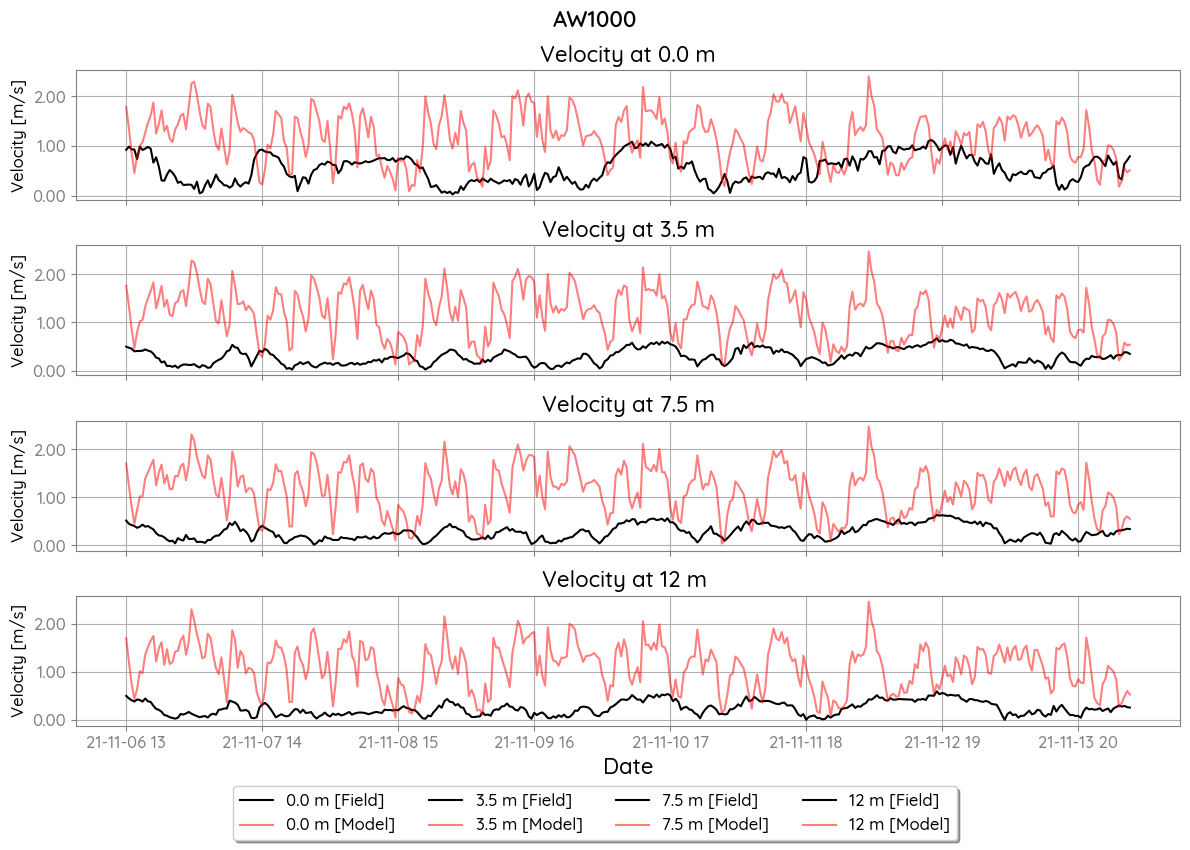

In [157]:
fig, axs = plt.subplots(len(df_field_aw1_plot.columns), 1, figsize = (12,8), sharex = True)
for k in range (len(df_field_aw1_plot.columns)):
    ax = axs[k]
    ticklabels = df_field_aw1_plot.index[::50]
    ax.plot(df_field_aw1_plot.iloc[:,k], label =df_field_aw1_plot.columns[k], color = 'k' )
    ax.plot(df_model_aw1_plot.iloc[:,k], label = df_model_aw1_plot.columns[k], color = 'red', alpha = 0.5)

    ax.set_xticks(ticklabels)
    date_format = mdates.DateFormatter('%y-%m-%d %H')
    ax.xaxis.set_major_formatter(date_format)
    ax.set_ylabel ('Velocity [m/s]',size=12,fontproperties=prop1)
    ax.set_yticklabels(ax.get_yticks(), fontproperties=prop1,color='gray',size = 12)
    ax.spines['left'].set_color('gray')
    ax.spines['right'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.spines['top'].set_color('gray')
    ax.tick_params('y', colors='tab:gray')
    ax.tick_params('x', colors='tab:gray')
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.set_title('Velocity at '+df_field_aw1_plot.columns[k][0:5],size = 16,fontproperties=prop1)   # Subtítulo de la figura
    ax.grid()
    for label in ax.get_xticklabels():
        label.set_fontproperties(prop1)
        label.set_color('gray')
        label.set_size(12)

ax.set_xlabel ('Date',size=16,fontproperties=prop1)
fig.suptitle("AW1000", size = 16,fontproperties=prop2)     # Titulo de la figura
fig.tight_layout()
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.02),
          fancybox=True, shadow=True, ncol=4, fontsize = 10,prop=prop1)

# plt.xticks(rotation=30);

# df_field_aw1_plot.iloc[:,0].plot(ax = ax)
# df_model_aw1_plot.iloc[:,0].plot(ax = ax)

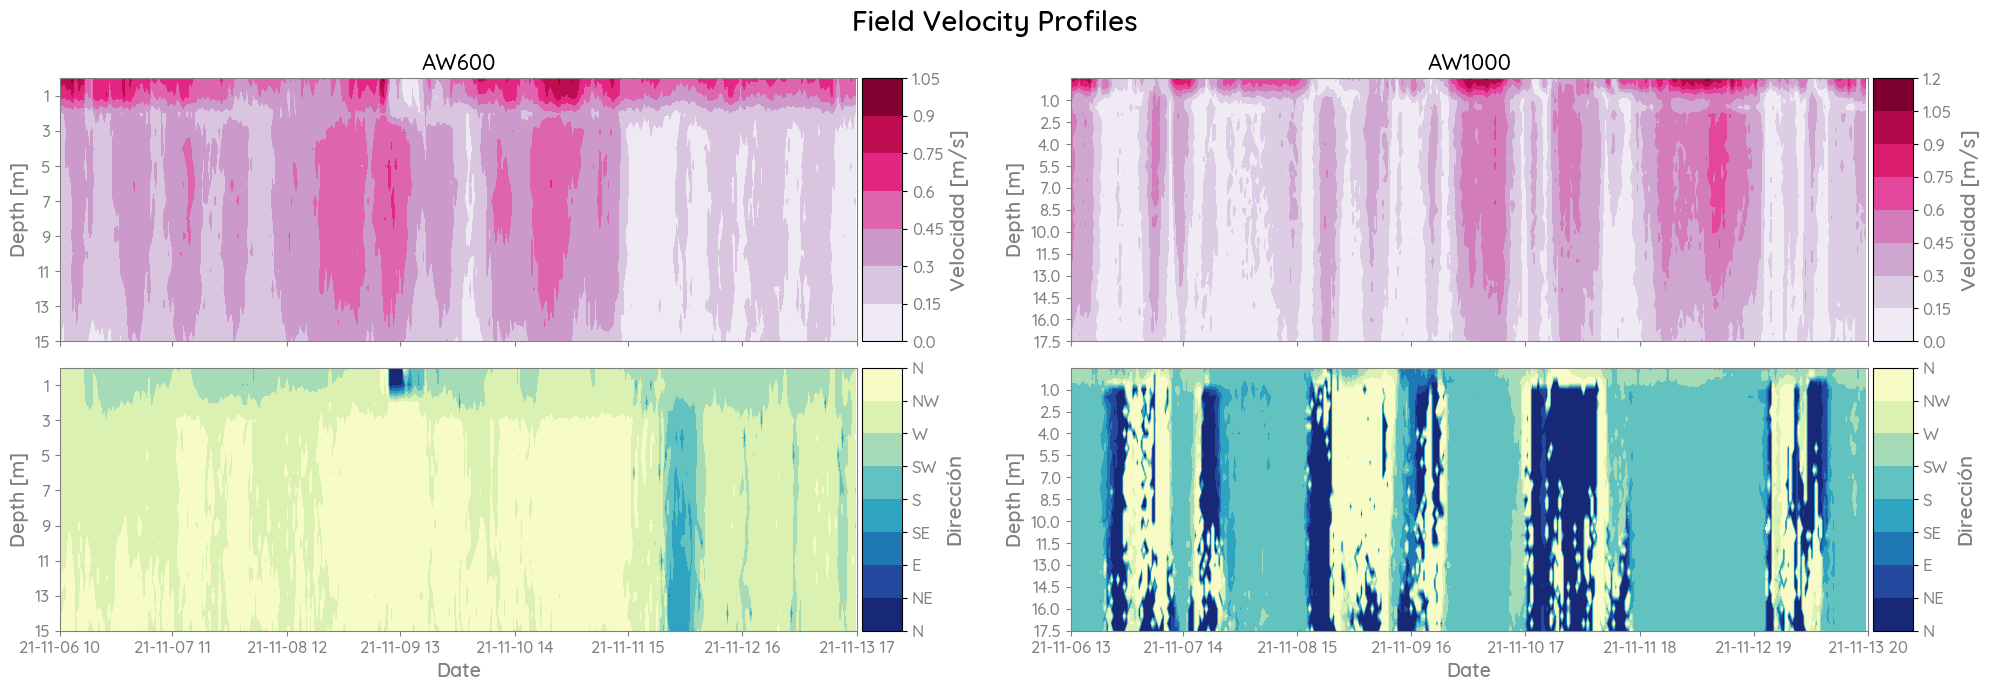

In [158]:
fig, axs = plt.subplots(2,2, figsize = (20, 7))
ax = axs[0,0]
x = np.arange(0,len(list(df_aw600_vel_field)),1)
y = np.arange(0,len(df_aw600_vel_field.index),1)
xx, yy = np.meshgrid(y,x)
xticks_time = df_aw600_vel_field.index[::50]
colormap = cm.PuRd
# colormap = cm.coolwarm

pc = ax.contourf(xx, yy, df_aw600_vel_field.transpose(),cmap=colormap)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cb =fig.colorbar(pc, cax=cax, orientation='vertical')
cb.set_label('Velocidad [m/s]',size=15,fontproperties=prop2, color = 'gray')
cb.set_ticklabels(list(round(i,2) for i in cb.get_ticks()) 
                  , fontproperties=prop1, color='gray',size=12)
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
yticks = np.arange(len(list(df_aw600_vel_field))-1,-1,-2)
ax.set_yticks(np.arange(0, len(list(df_aw600_vel_field)),2))
ax.set_yticklabels(yticks.round(2), fontproperties=prop1,color='gray',size = 12)
ax.set_xticks([int(np.linspace(0,len(df_aw600_vel_field.index),len(xticks_time))[i]) for i in range(len(np.linspace(0,len(df_aw600_vel_field.index),len(xticks_time))))])
ax.set_xticklabels(xlabels_aw6)
for label in ax.get_xticklabels():
    label.set_fontproperties(prop1)
    label.set_color('gray')
    label.set_size(12)
ax.spines['left'].set_color('gray')
ax.spines['right'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['top'].set_color('gray')
ax.tick_params('y', colors='tab:gray')
ax.tick_params('x', colors='tab:gray')
# ax.set_xlabel ('Date',size=14,fontproperties=prop2, color = 'gray')
ax.set_ylabel ('Depth [m]',size=14,fontproperties=prop2, color = 'gray')
ax.set_title('AW600',size = 16,fontproperties=prop1)   # Subtítulo de la figu
ax.set_xticklabels([])

#------------------------------- fig 1----------------------------------------------------
ax1 = axs[1,0]
ylabels = ['N','NE','E','SE','S','SW','W','NW','N']
cmap_reversed = cm.get_cmap('YlGnBu_r')
# pc = ax1.contourf(xx, yy, df_direc.transpose(),levels = np.arange(0,360+90,90),cmap=colormap)
pc = ax1.contourf(xx, yy, df_direc_aw600.transpose(),levels = np.arange(0,360+45,45),cmap=cmap_reversed)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
cb =fig.colorbar(pc, cax=cax, orientation='vertical')
cb.set_label('Dirección',size=15,fontproperties=prop2, color = 'gray')
cb.set_ticklabels(ylabels 
                  , fontproperties=prop1, color='gray',size=12)
# cb.set_ticklabels(list(round(i,2) for i in cb.get_ticks()) 
#                   , fontproperties=prop1, color='gray',size=12)
yticks = np.arange(len(list(df_direc_aw600))-1,-1,-2)
ax1.set_yticks(np.arange(0, len(list(df_direc_aw600)),2))
ax1.set_yticklabels(yticks, fontproperties=prop1,color='gray',size = 12)
ax1.set_xticks([int(np.linspace(0,len(df_direc_aw600.index),len(xticks_time))[i]) for i in range(len(np.linspace(0,len(df_direc_aw600.index),len(xticks_time))))])
ax1.set_xticklabels(xlabels_aw6)
for label in ax1.get_xticklabels():
    label.set_fontproperties(prop1)
    label.set_color('gray')
    label.set_size(12)
ax1.spines['left'].set_color('gray')
ax1.spines['right'].set_color('gray')
ax1.spines['bottom'].set_color('gray')
ax1.spines['top'].set_color('gray')
ax1.tick_params('y', colors='tab:gray')
ax1.tick_params('x', colors='tab:gray')
ax1.set_xlabel ('Date',size=14,fontproperties=prop2, color = 'gray')
ax1.set_ylabel ('Depth [m]',size=14,fontproperties=prop2, color = 'gray')
# ax1.set_title('AW600',size = 16,fontproperties=prop1)   # Subtítulo de la figu

#------------------------------- fig 2----------------------------------------------------
ax2 = axs[0,1]
x = np.arange(0,len(list(df_aw1000_vel_field)),1)
y = np.arange(0,len(df_aw1000_vel_field.index),1)
xx, yy = np.meshgrid(y,x)
xticks_time = df_aw1000_vel_field.index[::50]
colormap = cm.PuRd
# colormap = cm.coolwarm

pc = ax2.contourf(xx, yy, df_aw1000_vel_field.transpose(),cmap=colormap)
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
cb =fig.colorbar(pc, cax=cax, orientation='vertical')
cb.set_label('Velocidad [m/s]',size=15,fontproperties=prop2, color = 'gray')
cb.set_ticklabels(list(round(i,2) for i in cb.get_ticks()) 
                  , fontproperties=prop1, color='gray',size=12)
yticks = np.arange((len(list(df_aw1000_vel_field))*0.5)-1,-0.5,-1.5)
ax2.set_yticks(np.arange(0, len(list(df_aw1000_vel_field))-1,3))
ax2.set_yticklabels(yticks, fontproperties=prop1,color='gray',size = 12)
ax2.set_xticks([int(np.linspace(0,len(df_aw1000_vel_field.index),len(xticks_time))[i]) for i in range(len(np.linspace(0,len(df_aw1000_vel_field.index),len(xticks_time))))])
ax2.set_xticklabels(xlabels_aw1)
for label in ax2.get_xticklabels():
    label.set_fontproperties(prop1)
    label.set_color('gray')
    label.set_size(12)
ax2.spines['left'].set_color('gray')
ax2.spines['right'].set_color('gray')
ax2.spines['bottom'].set_color('gray')
ax2.spines['top'].set_color('gray')
ax2.tick_params('y', colors='tab:gray')
ax2.tick_params('x', colors='tab:gray')
# ax.set_xlabel ('Date',size=14,fontproperties=prop2, color = 'gray')
ax2.set_ylabel ('Depth [m]',size=14,fontproperties=prop2, color = 'gray')
ax2.set_title('AW1000',size = 16,fontproperties=prop1)   # Subtítulo de la figu
ax2.set_xticklabels([])


#------------------------------- fig 3----------------------------------------------------
ax3 = axs[1,1]

ylabels = ['N','NE','E','SE','S','SW','W','NW','N']
cmap_reversed = cm.get_cmap('YlGnBu_r')
# pc = ax3.contourf(xx, yy, df_direc.transpose(),levels = np.arange(0,360+90,90),cmap=colormap)
pc = ax3.contourf(xx, yy, df_direc_aw1000.transpose(),levels = np.arange(0,360+45,45),cmap=cmap_reversed)
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
cb =fig.colorbar(pc, cax=cax, orientation='vertical')
cb.set_label('Dirección',size=15,fontproperties=prop2, color = 'gray')
cb.set_ticklabels(ylabels 
                  , fontproperties=prop1, color='gray',size=12)
# cb.set_ticklabels(list(round(i,2) for i in cb.get_ticks()) 
#                   , fontproperties=prop1, color='gray',size=12)
yticks = np.arange((len(list(df_direc_aw1000))*0.5)-1,-0.5,-1.5)
ax3.set_yticks(np.arange(0, len(list(df_direc_aw1000))-1,3))
ax3.set_yticklabels(yticks, fontproperties=prop1,color='gray',size = 12)
ax3.set_xticks([int(np.linspace(0,len(df_direc_aw1000.index),len(xticks_time))[i]) for i in range(len(np.linspace(0,len(df_direc_aw1000.index),len(xticks_time))))])
ax3.set_xticklabels(xlabels_aw1)
for label in ax3.get_xticklabels():
    label.set_fontproperties(prop1)
    label.set_color('gray')
    label.set_size(12)
ax3.spines['left'].set_color('gray')
ax3.spines['right'].set_color('gray')
ax3.spines['bottom'].set_color('gray')
ax3.spines['top'].set_color('gray')
ax3.tick_params('y', colors='tab:gray')
ax3.tick_params('x', colors='tab:gray')
ax3.set_xlabel ('Date',size=14,fontproperties=prop2, color = 'gray')
ax3.set_ylabel ('Depth [m]',size=14,fontproperties=prop2, color = 'gray')

fig.suptitle("Field Velocity Profiles", size = 20,fontproperties=prop2)     # Titulo de la figura
fig.tight_layout()
plt.subplots_adjust(wspace=0.2)
plt.subplots_adjust(hspace=0.1)

## Water level

In [12]:
def marea_descomp(df):
    """
    Input: 
    - df of water level donde la columna del nivel dela agua se llame waterlevel
    ----------------------------------------------------------------------------
    Output:
    - df con marea astronómica y metereológica
    
    """
    my_tide = Tide.decompose(df['waterlevel'], df.index)
    df['astro_tide'] = my_tide.at(df.index)
    df['meteo_tide'] = df['waterlevel'] - df['astro_tide']
    return df

### Field data

In [13]:
# Club nautico AW600
path_wl_northest = r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\DATOS_CAMPO\DATOS_SAI_4_15_nov_2021\Aqualoggers\Aq04_ClubNautico/Aq_04_ClubNAutico_14Nov2021.csv"
ini_date = datetime.datetime(2021,11,8,10,0,0)                       # Entrar la fecha de inicio de toma de datos 
end_date = datetime.datetime(2021,11,14,11,0,0)                          # Entrar la fecha final de toma de datos
df_wl_northeast_field =  class_field_db_AW600.water_level (path = path_wl_northest, ini_date= ini_date, end_date = end_date)
df_wl_northeast_field = marea_descomp(df_wl_northeast_field)

# Cove AW1000
path_wl_west = r"G:\My Drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\DATOS_CAMPO\DATOS_SAI_4_15_nov_2021\Aqualoggers\Aq02_6 meses_MuelleCove/NivelMAr_Cove_6meses_13Nov2021.csv"
ini_date = datetime.datetime(2021,11,8,10,0,0)                       # Entrar la fecha de inicio de toma de datos 
end_date = datetime.datetime(2021,11,13,11,0,0)                          # Entrar la fecha final de toma de datos
df_wl_west_field =  class_field_db_AW1000.water_level (path = path_wl_west, ini_date = ini_date, end_date= end_date)
df_wl_west_field = marea_descomp(df_wl_west_field) 

<AxesSubplot:>

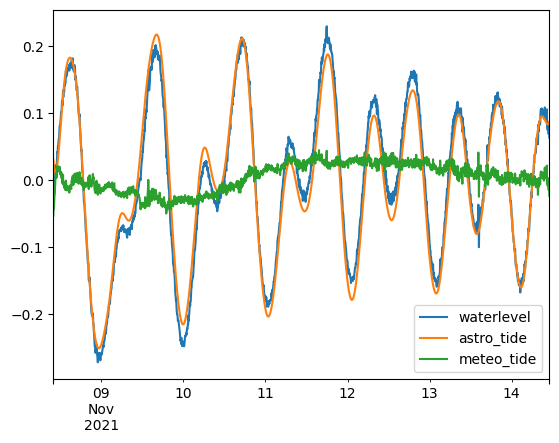

In [14]:
df_wl_northeast_field.plot()

<AxesSubplot:>

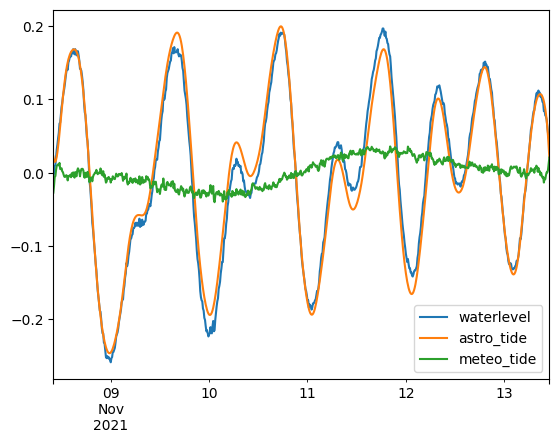

In [15]:
df_wl_west_field.plot()

### Model data

In [16]:
df_wl_ne_model = class_db_model_northeast.water_level()
df_wl_w_model = class_db_model_west.water_level()

# index_intersection 
df_field_model_northeast =df_wl_ne_model.loc[df_wl_northeast_field.index.intersection(df_wl_ne_model.index)]
df_field_model_northeast['waterlevel'] = df_field_model_northeast['waterlevel'] - df_field_model_northeast['waterlevel'].mean()

df_field_model_west =df_wl_w_model.loc[df_wl_west_field.index.intersection(df_wl_w_model.index)]
df_field_model_west['waterlevel'] = df_field_model_west['waterlevel'] - df_field_model_west['waterlevel'].mean()

df_field_model_northeast = marea_descomp(df_field_model_northeast)
df_field_model_west = marea_descomp(df_field_model_west)

<AxesSubplot:>

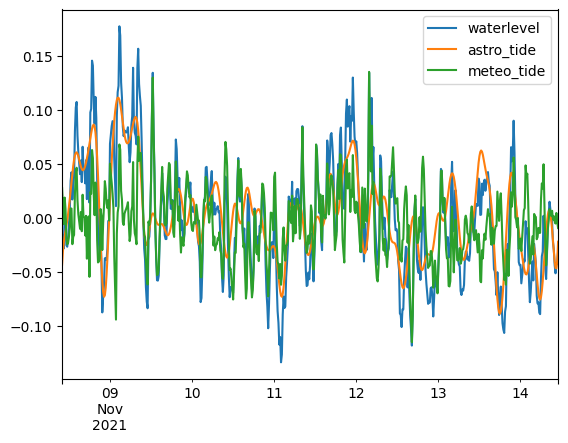

In [17]:
df_field_model_northeast.plot()

<AxesSubplot:>

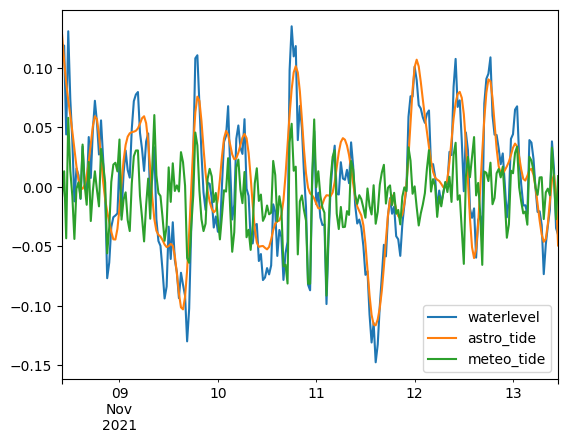

In [18]:
df_field_model_west.plot()

### Plot y análisis 

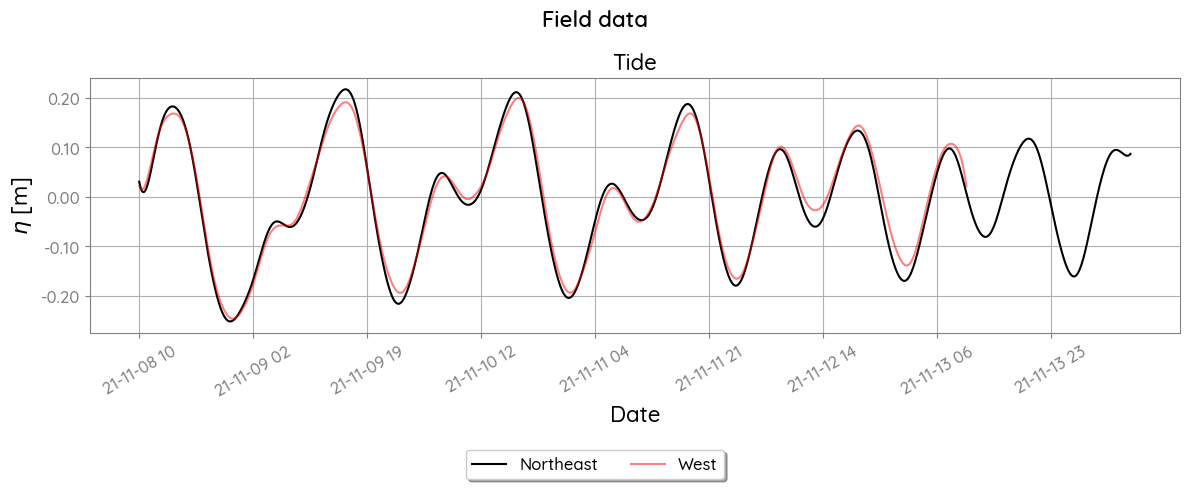

In [19]:
fig, ax = plt.subplots(figsize =(12,4))

ticklabels = df_wl_northeast_field.index[::200]
ax.plot(df_wl_northeast_field['astro_tide'], label ='Northeast', color = 'k' )
ax.plot(df_wl_west_field['astro_tide'], label = 'West', color = 'red', alpha = 0.5)

ax.set_xticks(ticklabels)
date_format = mdates.DateFormatter('%y-%m-%d %H')
ax.xaxis.set_major_formatter(date_format)
ax.set_ylabel ('$\eta$ [m]',size=16,fontproperties=prop1)
ax.set_xlabel ('Date',size=16,fontproperties=prop1)
ax.set_yticklabels(ax.get_yticks(), fontproperties=prop1,color='gray',size = 12)
ax.spines['left'].set_color('gray')
ax.spines['right'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['top'].set_color('gray')
ax.tick_params('y', colors='tab:gray')
ax.tick_params('x', colors='tab:gray')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_title('Tide',size = 16,fontproperties=prop1)   # Subtítulo de la figura
ax.grid()
for label in ax.get_xticklabels():
    label.set_fontproperties(prop1)
    label.set_color('gray')
    label.set_size(12)
fig.suptitle("Field data", size = 16,fontproperties=prop2)     # Titulo de la figura
fig.tight_layout()
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=4, fontsize = 10,prop=prop1)
plt.xticks(rotation=30);

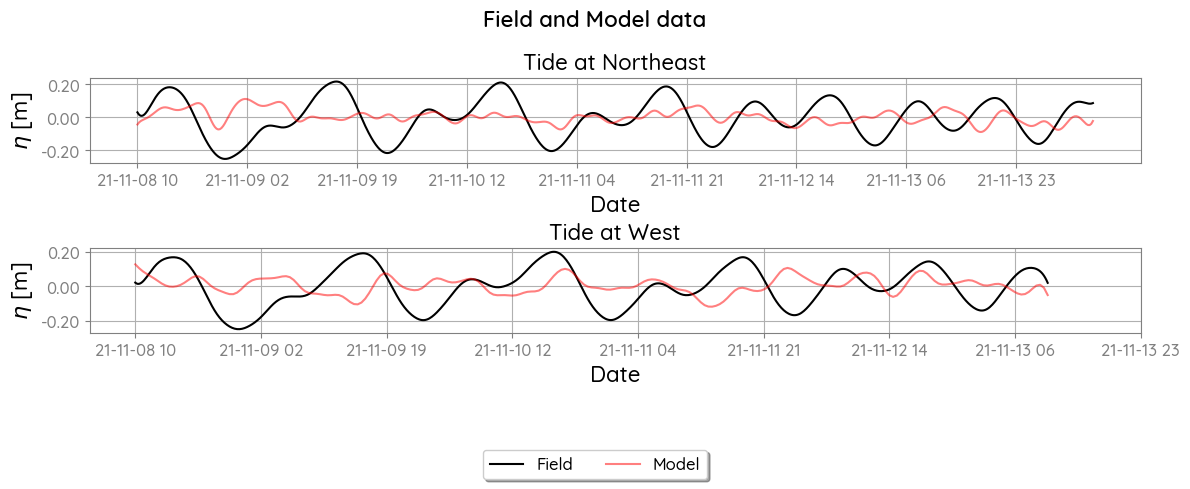

In [20]:
fig, axs = plt.subplots(2,1, figsize =(12,4))
ax = axs[0]
ticklabels = df_wl_northeast_field.index[::200]
ax.plot(df_wl_northeast_field['astro_tide'], label ='Field', color = 'k' )
ax.plot(df_field_model_northeast['astro_tide'], label = 'Model', color = 'red', alpha = 0.5)

ax.set_xticks(ticklabels)
date_format = mdates.DateFormatter('%y-%m-%d %H')
ax.xaxis.set_major_formatter(date_format)
ax.set_ylabel ('$\eta$ [m]',size=16,fontproperties=prop1)
ax.set_xlabel ('Date',size=16,fontproperties=prop1)
ax.set_yticklabels(ax.get_yticks(), fontproperties=prop1,color='gray',size = 12)
ax.spines['left'].set_color('gray')
ax.spines['right'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['top'].set_color('gray')
ax.tick_params('y', colors='tab:gray')
ax.tick_params('x', colors='tab:gray')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_title('Tide at Northeast',size = 16,fontproperties=prop1)   # Subtítulo de la figura
ax.grid()
for label in ax.get_xticklabels():
    label.set_fontproperties(prop1)
    label.set_color('gray')
    label.set_size(12)




ax1 = axs[1]
ticklabels = df_wl_northeast_field.index[::200]
ax1.plot(df_wl_west_field['astro_tide'], color = 'k' )
ax1.plot(df_field_model_west['astro_tide'], color = 'red', alpha = 0.5)

ax1.set_xticks(ticklabels)
date_format = mdates.DateFormatter('%y-%m-%d %H')
ax1.xaxis.set_major_formatter(date_format)
ax1.set_ylabel ('$\eta$ [m]',size=16,fontproperties=prop1)
ax1.set_xlabel ('Date',size=16,fontproperties=prop1)
ax1.set_yticklabels(ax1.get_yticks(), fontproperties=prop1,color='gray',size = 12)
ax1.spines['left'].set_color('gray')
ax1.spines['right'].set_color('gray')
ax1.spines['bottom'].set_color('gray')
ax1.spines['top'].set_color('gray')
ax1.tick_params('y', colors='tab:gray')
ax1.tick_params('x', colors='tab:gray')
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.set_title('Tide at West',size = 16,fontproperties=prop1)   # Subtítulo de la figura
ax1.grid()
for label in ax1.get_xticklabels():
    label.set_fontproperties(prop1)
    label.set_color('gray')
    label.set_size(12)

fig.suptitle("Field and Model data", size = 16,fontproperties=prop2)     # Titulo de la figura

fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=4, fontsize = 10,prop=prop1)
# plt.xticks(rotation=30);
fig.tight_layout()
plt.subplots_adjust(wspace=0.6)
plt.subplots_adjust(hspace=1)

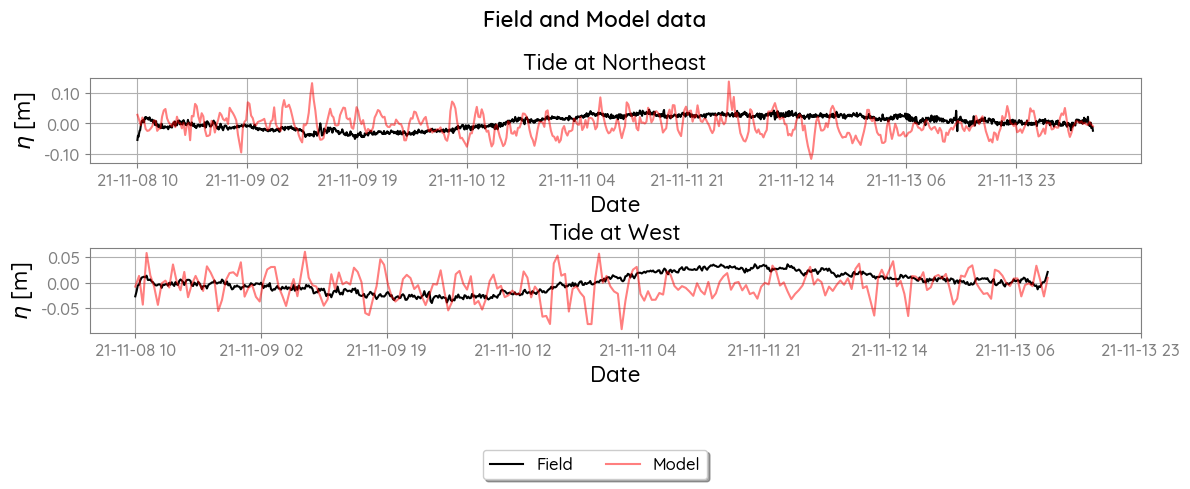

In [21]:
fig, axs = plt.subplots(2,1, figsize =(12,4))
ax = axs[0]
ticklabels = df_wl_northeast_field.index[::200]
ax.plot(df_wl_northeast_field['meteo_tide'], label ='Field', color = 'k' )
ax.plot(df_field_model_northeast['meteo_tide'], label = 'Model', color = 'red', alpha = 0.5)

ax.set_xticks(ticklabels)
date_format = mdates.DateFormatter('%y-%m-%d %H')
ax.xaxis.set_major_formatter(date_format)
ax.set_ylabel ('$\eta$ [m]',size=16,fontproperties=prop1)
ax.set_xlabel ('Date',size=16,fontproperties=prop1)
ax.set_yticklabels(ax.get_yticks(), fontproperties=prop1,color='gray',size = 12)
ax.spines['left'].set_color('gray')
ax.spines['right'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['top'].set_color('gray')
ax.tick_params('y', colors='tab:gray')
ax.tick_params('x', colors='tab:gray')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_title('Tide at Northeast',size = 16,fontproperties=prop1)   # Subtítulo de la figura
ax.grid()
for label in ax.get_xticklabels():
    label.set_fontproperties(prop1)
    label.set_color('gray')
    label.set_size(12)




ax1 = axs[1]
ticklabels = df_wl_northeast_field.index[::200]
ax1.plot(df_wl_west_field['meteo_tide'], color = 'k' )
ax1.plot(df_field_model_west['meteo_tide'], color = 'red', alpha = 0.5)

ax1.set_xticks(ticklabels)
date_format = mdates.DateFormatter('%y-%m-%d %H')
ax1.xaxis.set_major_formatter(date_format)
ax1.set_ylabel ('$\eta$ [m]',size=16,fontproperties=prop1)
ax1.set_xlabel ('Date',size=16,fontproperties=prop1)
ax1.set_yticklabels(ax1.get_yticks(), fontproperties=prop1,color='gray',size = 12)
ax1.spines['left'].set_color('gray')
ax1.spines['right'].set_color('gray')
ax1.spines['bottom'].set_color('gray')
ax1.spines['top'].set_color('gray')
ax1.tick_params('y', colors='tab:gray')
ax1.tick_params('x', colors='tab:gray')
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.set_title('Tide at West',size = 16,fontproperties=prop1)   # Subtítulo de la figura
ax1.grid()
for label in ax1.get_xticklabels():
    label.set_fontproperties(prop1)
    label.set_color('gray')
    label.set_size(12)

fig.suptitle("Field and Model data", size = 16,fontproperties=prop2)     # Titulo de la figura

fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=4, fontsize = 10,prop=prop1)
# plt.xticks(rotation=30);
fig.tight_layout()
plt.subplots_adjust(wspace=0.6)
plt.subplots_adjust(hspace=1)

In [ ]:
df_field_model_northeast

### Field data

In [ ]:
# AW600 
paths_aw600 = glob.glob(r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\DATOS_CAMPO\DATOS_SAI_4_15_nov_2021\AWAC600\*.wad")
paths_aw600 = sorted(paths_aw600)
df_aw600, time_aw600 = class_field_db_AW600.waves(paths=paths_aw600, samples= 1024, fecha_inicio=datetime.datetime(2021,11,6,11,0,0), fecha_fin=datetime.datetime(2021,11,14,7,0,0), fecha_ideploid= datetime.datetime(2021,11,6,11,0,0), fecha_fdeploid=datetime.datetime(2021,11,14,6,0,0))
dic_result_aw600= class_field_db_AW600.OCEANLYZ(data=df_aw600,freq_S=1, method='spectral', rho=1024, zp = 0.60, fmaxpcorr=0.50)
df_wave_aw600_field = pd.DataFrame({'Hs':dic_result_aw600['Hm0'], 'Tp':dic_result_aw600['Tp']}, index = time_aw600)

#AW1000
paths_aw1000 = glob.glob(r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\DATOS_CAMPO\DATOS_SAI_4_15_nov_2021\AWAC1000\*.wad")
paths_aw1000 = sorted(paths_aw1000) [2:-6] # Se eliminan los primeros burst donde el sensor estuvo por fuera del agua
df_aw1000, time_aw1000 = class_field_db_AW1000. waves(paths=paths_aw1000, samples= 2048, fecha_inicio=datetime.datetime(2021,11,6,13,0,0), fecha_fin=datetime.datetime(2021,11,14,7,0,0), fecha_ideploid= datetime.datetime(2021,11,6,9,0), fecha_fdeploid=datetime.datetime(2021,11,14,8,59,59))
dic_result_aw1000 = class_field_db_AW1000.OCEANLYZ(data=df_aw1000,freq_S=2, method='spectral', rho=2048, zp = 0.60, fmaxpcorr=0.80)
df_wave_aw1000_field = pd.DataFrame({'Hs':dic_result_aw1000['Hm0'], 'Tp':dic_result_aw1000['Tp']}, index = time_aw1000)

### Model Data

In [ ]:
df_wave_aw600_model = class_db_model_northeast.wave(ind_x=108, ind_y=125)
df_wave_aw1000_model = class_db_model_west.wave(ind_x=75, ind_y=99)

# Data Frame durante campo
df_wave_model_aw600 = df_wave_aw600_model[df_wave_aw600_field.index[0]:df_wave_aw600_field.index[-1]]
df_wave_model_aw1000 = df_wave_aw1000_model[df_wave_aw1000_field.index[0]:df_wave_aw600_field.index[-1]]

### Plots y análisis

In [ ]:
# index_intersection 
df_field_model_aw600 =df_wave_model_aw600.loc[df_wave_aw600_field.index.intersection(df_wave_model_aw600.index)]
df_field_model_aw1000 =df_wave_model_aw1000.loc[df_wave_aw1000_field.index.intersection(df_wave_model_aw1000.index)]

In [ ]:
# Model data 
fig, axs = plt.subplots(2,1, figsize =(12,7), sharex = True)
ax = axs[0]
ticklabels = df_wave_aw600_field.index[::15]
ax.plot(df_wave_aw600_field['Hs'], label ='Northeast', color = 'k' )
ax.plot(df_wave_aw1000_field['Hs'], label = 'West', color = 'red', alpha = 0.5)

ax.set_xticks(ticklabels)
date_format = mdates.DateFormatter('%y-%m-%d %H')
ax.xaxis.set_major_formatter(date_format)
ax.set_ylabel ('H$_s$ [m]',size=16,fontproperties=prop1)
ax.set_yticklabels(ax.get_yticks(), fontproperties=prop1,color='gray',size = 12)
ax.spines['left'].set_color('gray')
ax.spines['right'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['top'].set_color('gray')
ax.tick_params('y', colors='tab:gray')
ax.tick_params('x', colors='tab:gray')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_title('Significant wave height',size = 16,fontproperties=prop1)   # Subtítulo de la figura
ax.grid()

ax1 = axs[1]

ax1.plot(df_wave_aw600_field['Tp'], color = 'k' )
ax1.plot(df_wave_aw1000_field['Tp'], color = 'red', alpha = 0.5)

ax1.set_ylabel ('T$_p$ [s]',size=16,fontproperties=prop1)
ax1.set_xlabel ('Date',size=16,fontproperties=prop1)
for label in ax1.get_xticklabels():
    label.set_fontproperties(prop1)
    label.set_color('gray')
    label.set_size(12)
ax1.spines['left'].set_color('gray')
ax1.spines['right'].set_color('gray')
ax1.spines['bottom'].set_color('gray')
ax1.spines['top'].set_color('gray')
ax1.tick_params('y', colors='tab:gray')
ax1.tick_params('x', colors='tab:gray')
ax1.set_title('Peak Period',size = 16,fontproperties=prop1)   # Subtítulo de la figura
ax1.grid()

fig.suptitle("Field data", size = 16,fontproperties=prop2)     # Titulo de la figura

fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.001),
          fancybox=True, shadow=True, ncol=4, fontsize = 10,prop=prop1)
plt.xticks(rotation=30);

fig.tight_layout()
plt.subplots_adjust(wspace=0.2)
plt.subplots_adjust(hspace=0.2)


In [ ]:
# Model data 
fig, axs = plt.subplots(2,1, figsize =(12,7), sharex = True)
ax = axs[0]
ticklabels = df_wave_aw600_field.index[::15]
ax.plot(df_wave_aw600_field['Hs'], label ='Field', color = 'k' )
ax.plot(df_field_model_aw600['Hs'], label = 'Model', color = 'red', alpha = 0.5)

ax.set_xticks(ticklabels)
date_format = mdates.DateFormatter('%y-%m-%d %H')
ax.xaxis.set_major_formatter(date_format)
ax.set_ylabel ('H$_s$ [m]',size=16,fontproperties=prop1)
ax.set_yticklabels(ax.get_yticks(), fontproperties=prop1,color='gray',size = 12)
ax.spines['left'].set_color('gray')
ax.spines['right'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['top'].set_color('gray')
ax.tick_params('y', colors='tab:gray')
ax.tick_params('x', colors='tab:gray')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_title('Significant wave height at Northesat',size = 16,fontproperties=prop1)   # Subtítulo de la figura
ax.grid()

ax1 = axs[1]
ax1.plot(df_wave_aw1000_field['Hs'],color = 'k' )
ax1.plot(df_field_model_aw1000['Hs'],color = 'red', alpha = 0.5)

ax1.set_ylabel ('H$_s$ [m]',size=16,fontproperties=prop1)
ax1.set_xlabel ('Date',size=16,fontproperties=prop1)
ax1.set_yticklabels(ax.get_yticks(), fontproperties=prop1,color='gray',size = 12)
ax1.spines['left'].set_color('gray')
ax1.spines['right'].set_color('gray')
ax1.spines['bottom'].set_color('gray')
ax1.spines['top'].set_color('gray')
ax1.tick_params('y', colors='tab:gray')
ax1.tick_params('x', colors='tab:gray')
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.set_title('Significant wave height at West',size = 16,fontproperties=prop1)   # Subtítulo de la figura
ax1.grid()



for label in ax1.get_xticklabels():
    label.set_fontproperties(prop1)
    label.set_color('gray')
    label.set_size(12)
    
plt.subplots_adjust(wspace=0.6)
plt.subplots_adjust(hspace=0.5)

fig.suptitle("Field data", size = 16,fontproperties=prop2)     # Titulo de la figura

fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.001),
          fancybox=True, shadow=True, ncol=4, fontsize = 10,prop=prop1)
plt.xticks(rotation=30)
fig.tight_layout()
plt.subplots_adjust(wspace=0.2)
plt.subplots_adjust(hspace=0.2)

## Salinity an Temperature

### Field data

In [ ]:
# Paths global points
paths_g = glob.glob(r"G:\My Drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\DATOS_CAMPO\DATOS_SAI_4_15_nov_2021\CTD\Datos_CTD_CSV\*.csv")
paths_g = sorted(paths_g)

# Paths emissary points 
paths_em = glob.glob(r"G:\My Drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\DATOS_CAMPO\DATOS_SAI_4_15_nov_2021\CTD\Emisario\Datos_CTD_131121_CSV\*.csv")
paths_em = sorted(paths_em)

# Paths jonny Cay points
paths_jc = glob.glob(r"G:\My Drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\DATOS_CAMPO\DATOS_SAI_4_15_nov_2021\CTD\Jhonny_Cay\*.csv")
paths_jc = sorted(paths_jc)
# paths
paths_all = paths_g + paths_em + paths_jc

dic_data, Cords = class_field_db_AW1000.dic_sal_temp(paths = paths_all)

### Model data

```ojo se debe crear la funcion para leer los perfiles de salinidad y temperatura en los puntos de medición```